In [4]:
import pandas as pd
import numpy as np
import os

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.samplers import TPESampler

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hasibur013/diabetes-dataset")
print("Path to dataset files:", path)

csv_file_path = os.path.join(path, "diabetes_dataset.csv")

df = pd.read_csv(csv_file_path)
df.head()

Path to dataset files: C:\Users\rustem_izmailov\.cache\kagglehub\datasets\hasibur013\diabetes-dataset\versions\1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Data preparation and data cleaning

In [3]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pregnancies               768 non-null    int64  
 1   glucose                   768 non-null    int64  
 2   bloodpressure             768 non-null    int64  
 3   skinthickness             768 non-null    int64  
 4   insulin                   768 non-null    int64  
 5   bmi                       768 non-null    float64
 6   diabetespedigreefunction  768 non-null    float64
 7   age                       768 non-null    int64  
 8   outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df_train, df_test = train_test_split(df, test_size=.2, shuffle=True, random_state=42)
print('df sixe:', df.shape[0])
print('df_train sixe:', df_train.shape[0])
print('df_test sixe:', df_test.shape[0])

X_train = df_train.drop(['outcome'], axis=1)
X_test = df_test.drop(['outcome'], axis=1)

y_train = df_train.outcome.values
y_test = df_test.outcome.values

df sixe: 768
df_train sixe: 614
df_test sixe: 154


# EDA

In [5]:
df_train.isna().sum()

pregnancies                 0
glucose                     0
bloodpressure               0
skinthickness               0
insulin                     0
bmi                         0
diabetespedigreefunction    0
age                         0
outcome                     0
dtype: int64

In [6]:
df_train.outcome.mean()

0.3469055374592834

In [7]:
X_train.corrwith(df_train.outcome).abs().sort_values(ascending = False)

glucose                     0.456117
bmi                         0.306335
age                         0.280654
pregnancies                 0.207550
diabetespedigreefunction    0.154560
insulin                     0.108498
bloodpressure               0.082046
skinthickness               0.057912
dtype: float64

In [8]:
X_train.describe()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.742671,120.855049,69.415309,20.399023,81.438111,31.983388,0.469168,32.907166
std,3.313264,32.035057,18.512599,15.433974,116.234835,7.740625,0.336847,11.503437
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,0.000000,0.000000,27.100000,0.241500,24.000000
50%,3.000000,117.000000,72.000000,23.000000,42.500000,32.000000,0.372500,29.000000
75%,6.000000,139.000000,80.000000,32.000000,129.750000,36.375000,0.613750,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


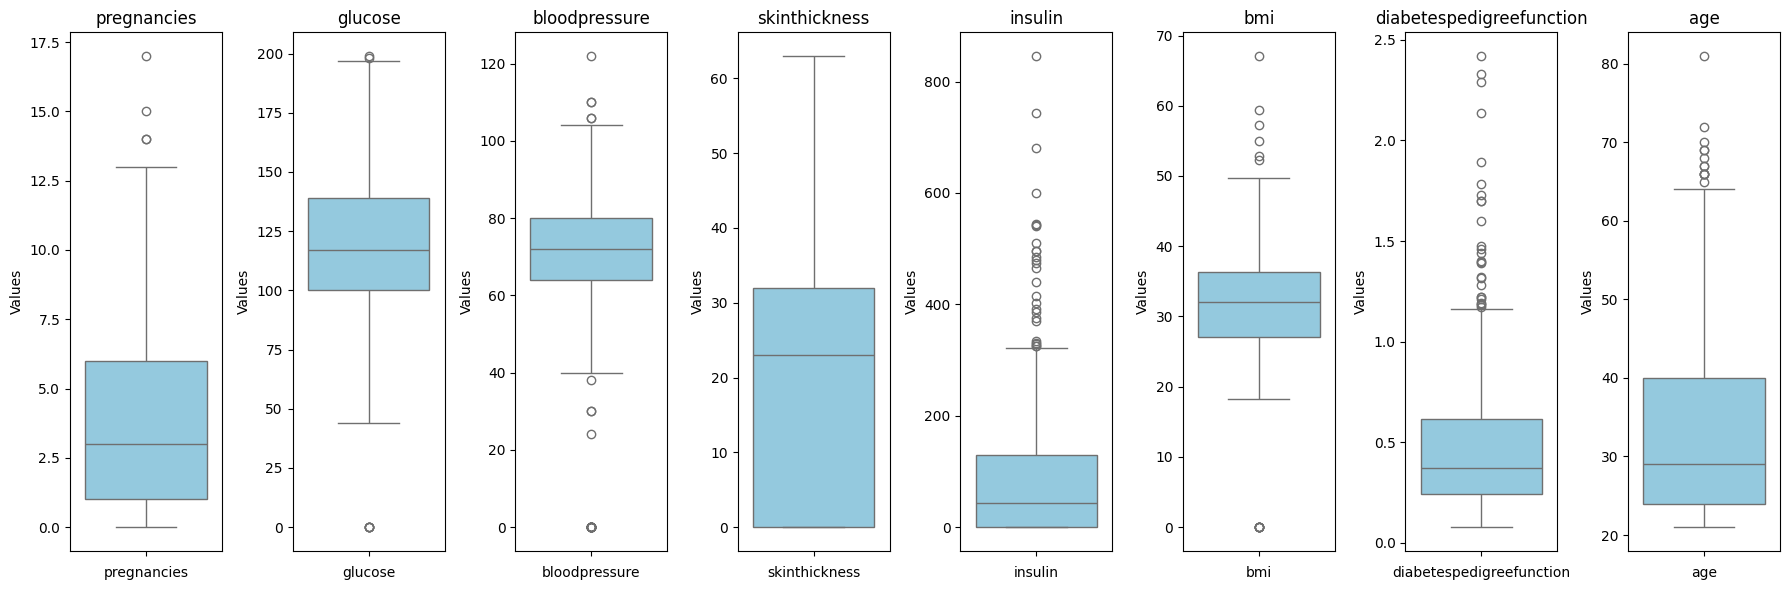

In [9]:
features_to_plot = X_train.columns

fig, axes = plt.subplots(1, len(features_to_plot), figsize=(18, 6), sharey=False)

for i, feature in enumerate(features_to_plot):
    sns.boxplot(data=X_train, y=feature, ax=axes[i], color='skyblue')
    axes[i].set_title(f'{feature}')
    axes[i].set_ylabel('Values')
    axes[i].set_xlabel(feature)

plt.tight_layout()
plt.show()

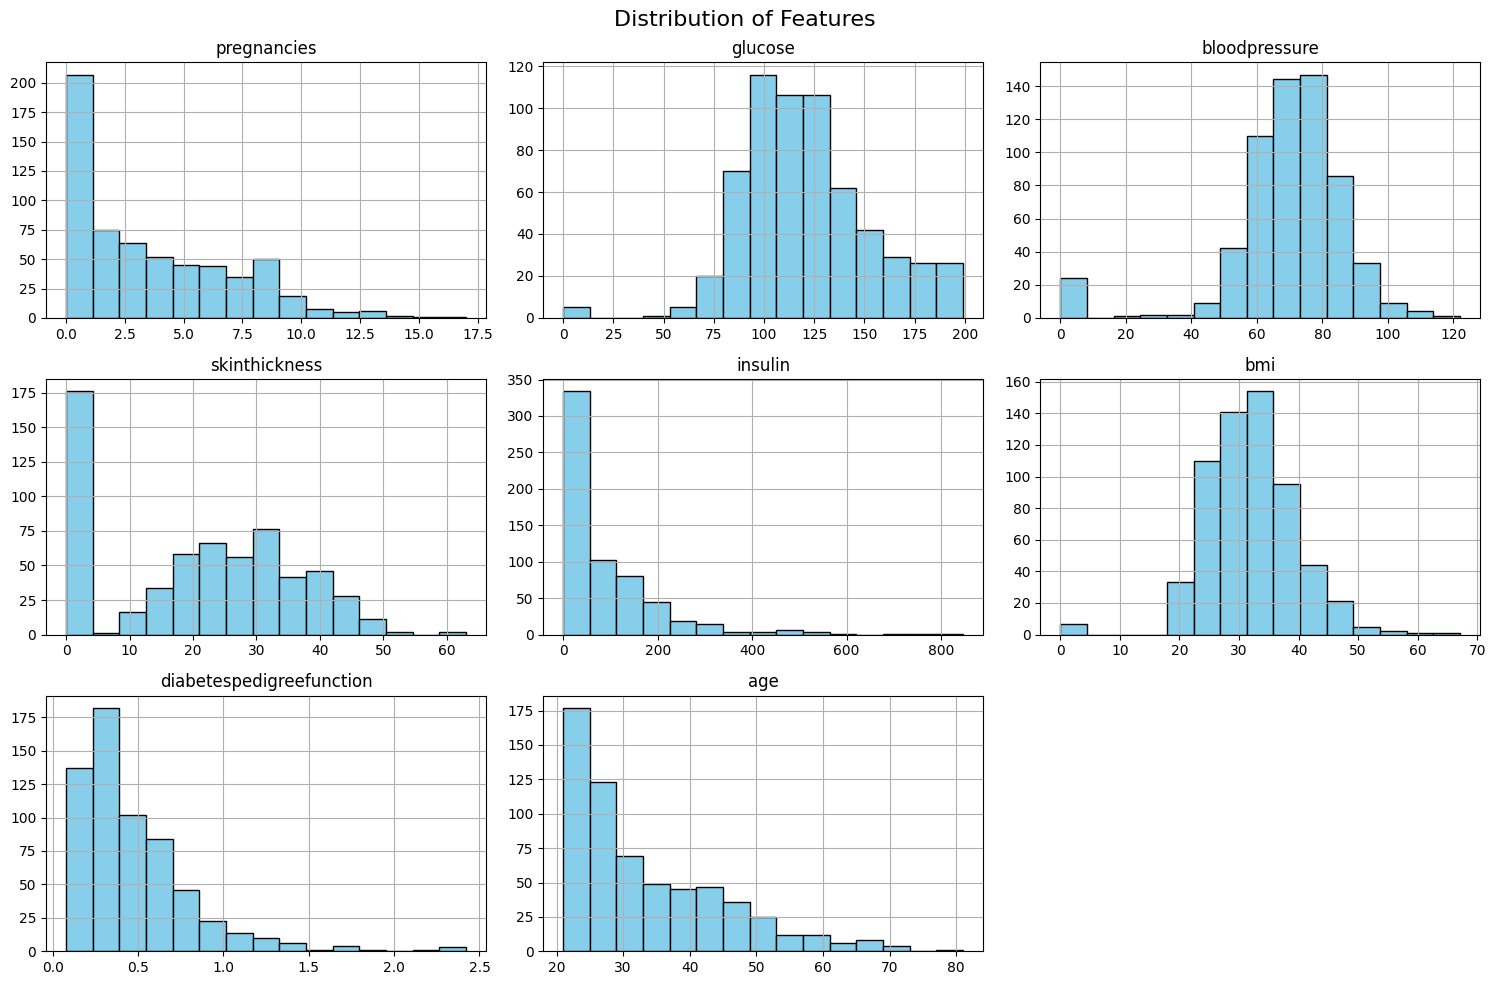

In [10]:
X_train.hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Features', fontsize=16)
plt.tight_layout()
plt.show()

Type 1 diabetes: In people with Type 1 diabetes, the pancreas produces little to no insulin. This causes a buildup of glucose in the bloodstream, which is called hyperglycemia. 

Insulin sensitivity: A study found that 35.7% of people with Type 2 diabetes had zero insulin sensitivity. 

In [11]:
print(y_train.mean())
print(df_train[df_train.insulin==0].outcome.mean())

0.3469055374592834
0.3793103448275862


It seems like glucose, bloodpressure, skinthikness, bmi cannot be 0, so it's better to try different approaches: hold zero valuse, replace 0 by mean valuse

In [12]:
def simulate_distribution(series):
    data = series
    non_zero_data = data[data != 0]
    mean = np.mean(non_zero_data)
    std = np.std(non_zero_data)
    
    replacement_values = np.random.normal(mean, std, size=(data == 0).sum()).astype(int)
    data[data == 0] = replacement_values

    return data

# try:
for col in ['glucose', 'bloodpressure', 'skinthickness', 'bmi',]:
    print(col)
    data = df_train[col].copy()
    print(f'Distribution of raw data:\t\t\tmean: {data.mean()}, std: {data.std()}')
    non_zero_data = data[data > 0]
    print(f'Distribution of data without zeros:\t\tmean: {non_zero_data.mean()}, std: {non_zero_data.std()}')

    updated_data = simulate_distribution(data)
    print(f'Distribution of updated data without zeros:\tmean: {updated_data.mean()}, std: {updated_data.std()}')
    print()

glucose
Distribution of raw data:			mean: 120.85504885993485, std: 32.03505673906218
Distribution of data without zeros:		mean: 121.84729064039409, std: 30.22554465002605
Distribution of updated data without zeros:	mean: 121.89413680781759, std: 30.139320836903426

bloodpressure
Distribution of raw data:			mean: 69.41530944625407, std: 18.512598597636224
Distribution of data without zeros:		mean: 72.23898305084745, std: 12.343231092496335
Distribution of updated data without zeros:	mean: 72.21824104234528, std: 12.273976482602297

skinthickness
Distribution of raw data:			mean: 20.39902280130293, std: 15.433974484062205
Distribution of data without zeros:		mean: 28.595890410958905, std: 9.960502386254909
Distribution of updated data without zeros:	mean: 28.65960912052117, std: 10.029797229924013

bmi
Distribution of raw data:			mean: 31.98338762214984, std: 7.740625077902246
Distribution of data without zeros:		mean: 32.35222405271829, std: 6.975458452530907
Distribution of updated dat

Insulin has 'longtail'. I would like also test if log1p(Insulin) will increase the score of the model

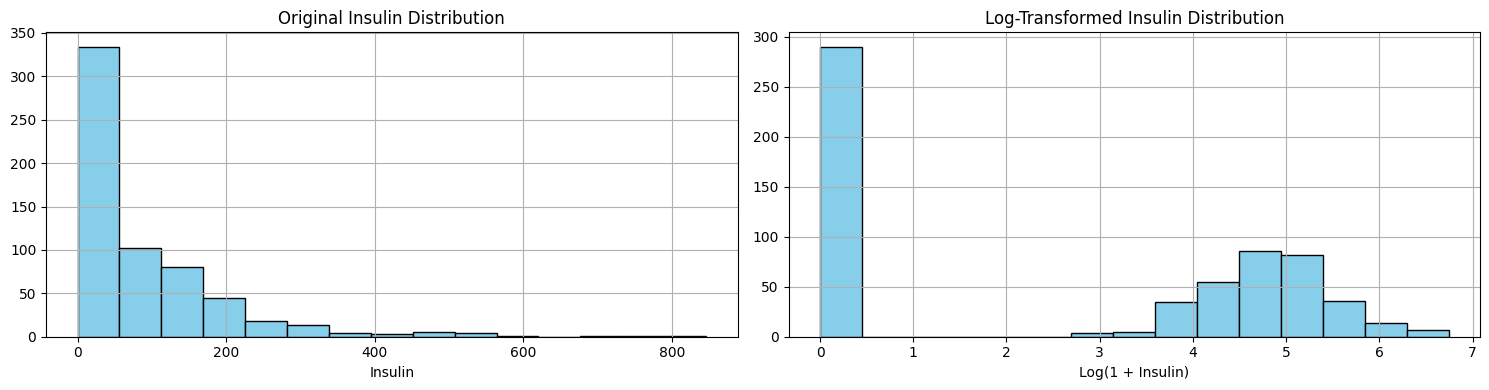

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=False)

# Plot the histogram of the original 'insulin' data
X_train['insulin'].hist(bins=15, color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Original Insulin Distribution')
axes[0].set_xlabel('Insulin')

# Plot the histogram of the log-transformed 'insulin' data
np.log1p(X_train['insulin']).hist(bins=15, color='skyblue', edgecolor='black', ax=axes[1])
axes[1].set_title('Log-Transformed Insulin Distribution')
axes[1].set_xlabel('Log(1 + Insulin)')


plt.tight_layout()
plt.show()

# Model selection

## Baseline models

In [109]:
kfold = KFold(n_splits=3, shuffle = True, random_state=42)

### Features without mdification

In [113]:
def baseline_scoring(X_train, y_train, kfold):
    models = {
        'LogisticRegression': LogisticRegression(),
        'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoostClassifier': XGBClassifier(objective='binary:logistic', random_state=42),
        'CatBoostClassifier': CatBoostClassifier(verbose = False, random_state=42)
        }

    all_scores = {
        'Algorithm': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': []
    }

    results = []


    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
    }

    for name, model in models.items():
        cv_results = cross_validate(model, X_train, y_train, scoring=scoring, cv=kfold, return_train_score=False)
        results.append({
            'Algorithm': name,
            'accuracy_score': f'{cv_results['test_accuracy'].mean().round(3)} +- {cv_results['test_accuracy'].std().round(4)}',
            'precision_score': f'{cv_results['test_precision'].mean().round(3)} +- {cv_results['test_precision'].std().round(4)}',
            'recall_score': f'{cv_results['test_recall'].mean().round(3)} +- {cv_results['test_recall'].std().round(4)}',
            'f1_score': f'{cv_results['test_f1'].mean().round(3)} +- {cv_results['test_f1'].std().round(4)}',
            'roc_auc': f'{cv_results['test_roc_auc'].mean().round(3)} +- {cv_results['test_roc_auc'].std().round(4)}'
            })
        
        all_scores['Algorithm'].extend([name] * len(cv_results['test_accuracy']))
        all_scores['accuracy'].extend(cv_results['test_accuracy'])
        all_scores['precision'].extend(cv_results['test_precision'])
        all_scores['recall'].extend(cv_results['test_recall'])
        all_scores['f1'].extend(cv_results['test_f1'])
        all_scores['roc_auc'].extend(cv_results['test_roc_auc'])

    df_results = pd.DataFrame(results)
    df_scores = pd.DataFrame(all_scores)

    return df_results, df_scores

def plot_baseline_scores(df_scores):
    plt.figure(figsize=(14, 8))
    for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
        plt.subplot(2, 3, i + 1)
        sns.boxplot(x='Algorithm', y=metric, data=df_scores)
        plt.title(metric)
        plt.xticks(rotation=45, ha = 'right')

    plt.tight_layout()
    plt.show()


In [ ]:
df_results, df_scores = baseline_scoring(X_train, y_train, kfold)

In [112]:
df_results

,Algorithm,accuracy_score,precision_score,recall_score,f1_score,roc_auc
0,LogisticRegression,0.754 +- 0.0089,0.703 +- 0.0459,0.512 +- 0.0492,0.589 +- 0.0218,0.822 +- 0.0061
1,DecisionTreeClassifier,0.689 +- 0.0266,0.556 +- 0.0613,0.564 +- 0.0266,0.557 +- 0.0219,0.66 +- 0.0142
2,RandomForestClassifier,0.769 +- 0.0164,0.694 +- 0.0377,0.604 +- 0.0396,0.644 +- 0.0133,0.824 +- 0.0151
3,XGBoostClassifier,0.749 +- 0.0223,0.649 +- 0.0531,0.605 +- 0.0148,0.625 +- 0.0321,0.815 +- 0.0203
4,CatBoostClassifier,0.762 +- 0.0026,0.679 +- 0.0386,0.594 +- 0.0635,0.631 +- 0.0399,0.831 +- 0.0124


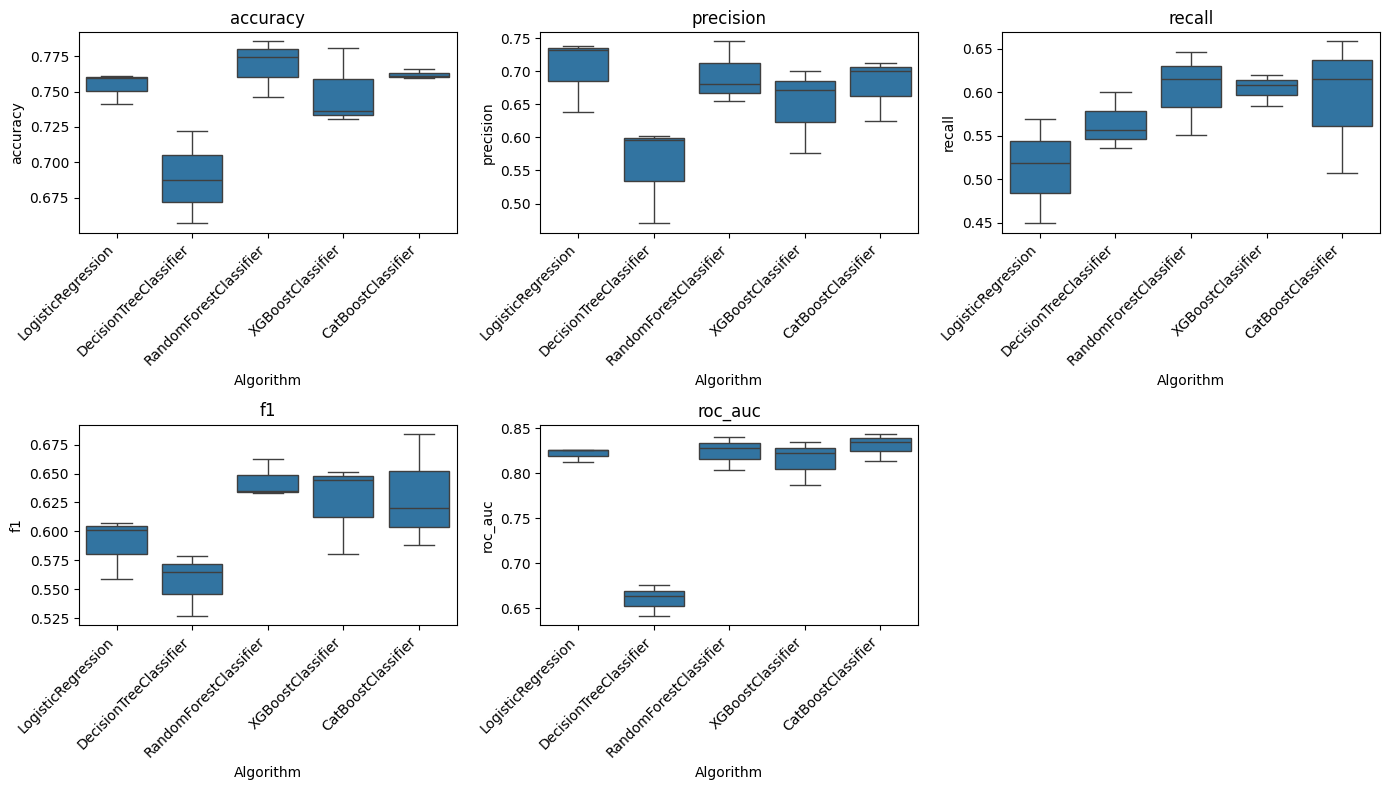

In [114]:
plot_baseline_scores(df_scores)

### Modified features with zeros

In [118]:
X_mod_train = X_train.copy()

for col in ['glucose', 'bloodpressure', 'skinthickness', 'bmi',]:
    data = df_train[col].copy()
    X_mod_train[col] = simulate_distribution(data)

In [ ]:
df_results, df_scores = baseline_scoring(X_mod_train, y_train, kfold)

In [116]:
df_results

,Algorithm,accuracy_score,precision_score,recall_score,f1_score,roc_auc
0,LogisticRegression,0.736 +- 0.0411,0.661 +- 0.0551,0.514 +- 0.0398,0.576 +- 0.0266,0.811 +- 0.0482
1,DecisionTreeClassifier,0.687 +- 0.0238,0.553 +- 0.011,0.512 +- 0.0134,0.531 +- 0.0036,0.646 +- 0.0123
2,RandomForestClassifier,0.761 +- 0.004,0.679 +- 0.0434,0.595 +- 0.0626,0.63 +- 0.03,0.817 +- 0.0123
3,XGBoostClassifier,0.749 +- 0.0194,0.657 +- 0.0305,0.586 +- 0.0356,0.618 +- 0.0087,0.808 +- 0.0192
4,CatBoostClassifier,0.752 +- 0.0056,0.66 +- 0.0309,0.591 +- 0.0603,0.621 +- 0.0314,0.828 +- 0.0153


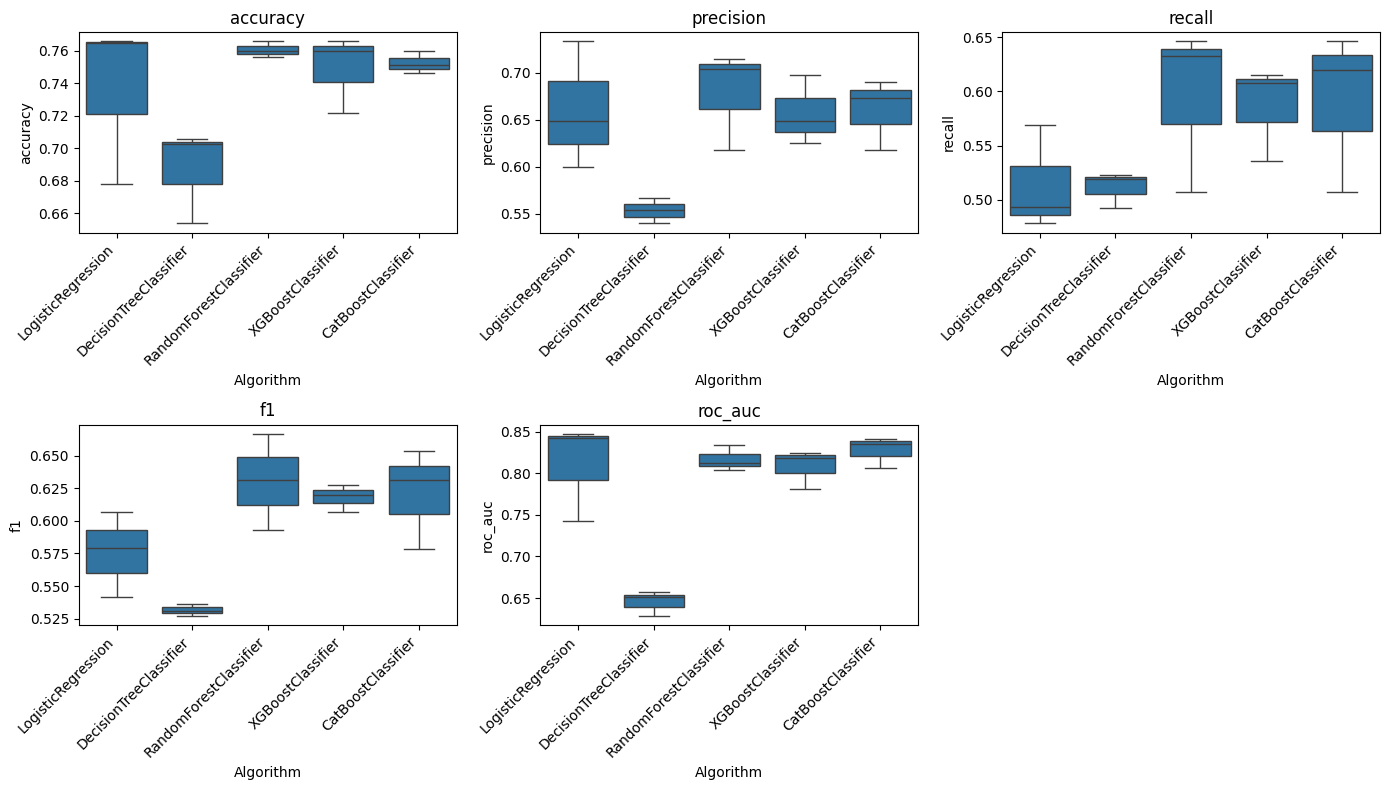

In [117]:
plot_baseline_scores(df_scores)

### Modified feature "insulin" with long tail

In [119]:
X_mod_2_train = X_mod_train.copy()

X_mod_2_train['insulin'] = np.log1p(X_mod_2_train['insulin'])

In [120]:
df_results, df_scores = baseline_scoring(X_mod_2_train, y_train, kfold)

In [121]:
df_results

,Algorithm,accuracy_score,precision_score,recall_score,f1_score,roc_auc
0,LogisticRegression,0.764 +- 0.0134,0.709 +- 0.0704,0.547 +- 0.0531,0.614 +- 0.0409,0.828 +- 0.0125
1,DecisionTreeClassifier,0.669 +- 0.012,0.523 +- 0.0264,0.523 +- 0.0553,0.521 +- 0.032,0.634 +- 0.0063
2,RandomForestClassifier,0.769 +- 0.0118,0.694 +- 0.0534,0.603 +- 0.0505,0.642 +- 0.0266,0.815 +- 0.0068
3,XGBoostClassifier,0.735 +- 0.0126,0.625 +- 0.0221,0.585 +- 0.0284,0.604 +- 0.0174,0.794 +- 0.0124
4,CatBoostClassifier,0.752 +- 0.0095,0.657 +- 0.0194,0.588 +- 0.0622,0.62 +- 0.0416,0.823 +- 0.0079


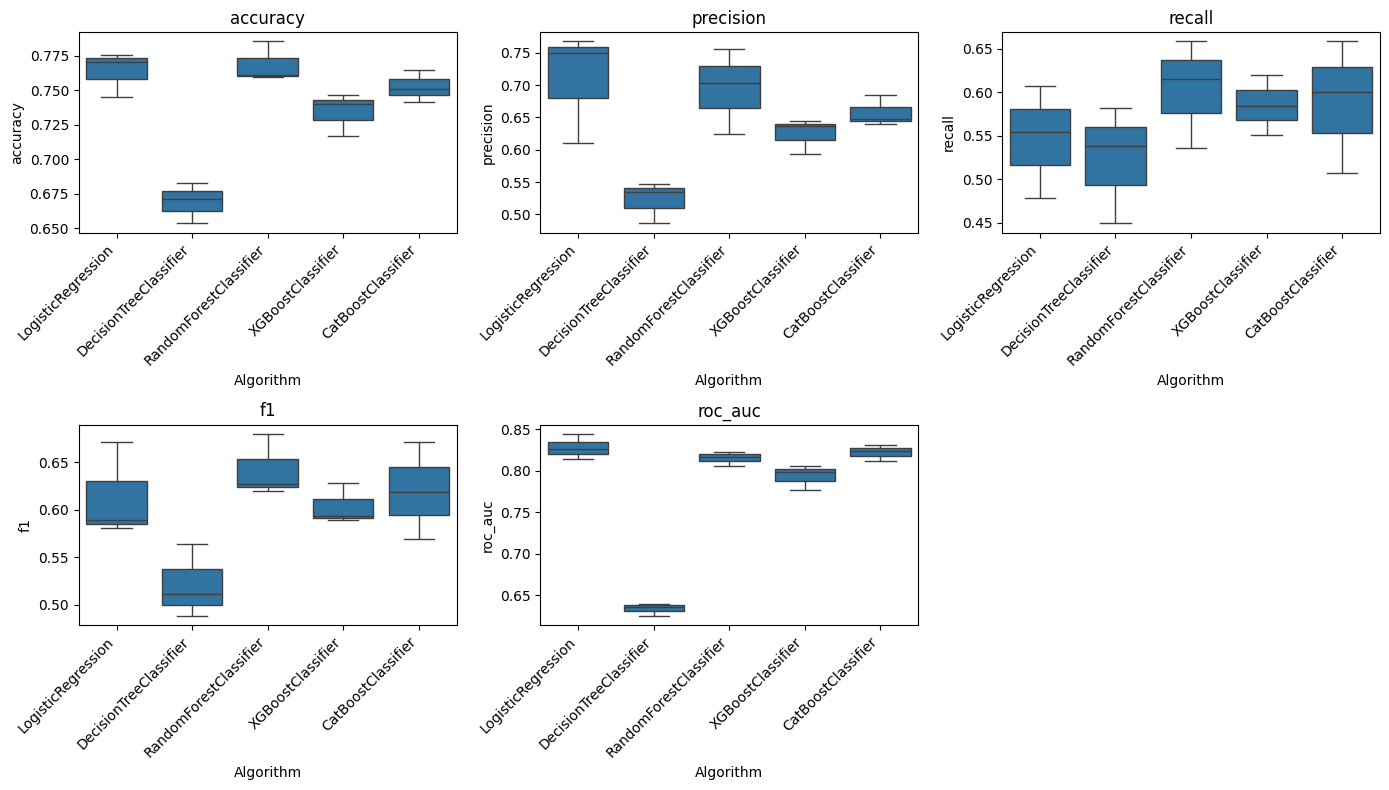

In [122]:
plot_baseline_scores(df_scores)

Without feature modification

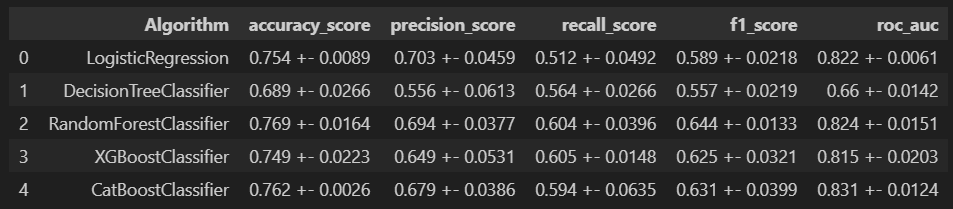

Modified features with zeros

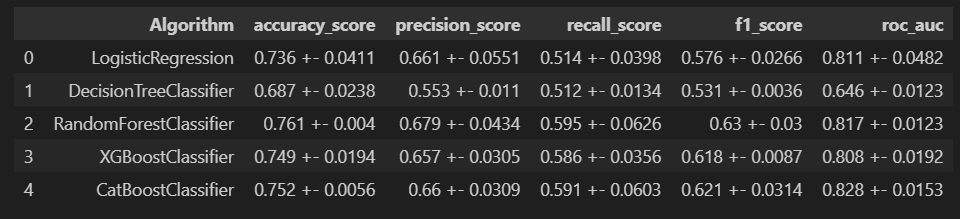

Modified feature 'insulin'

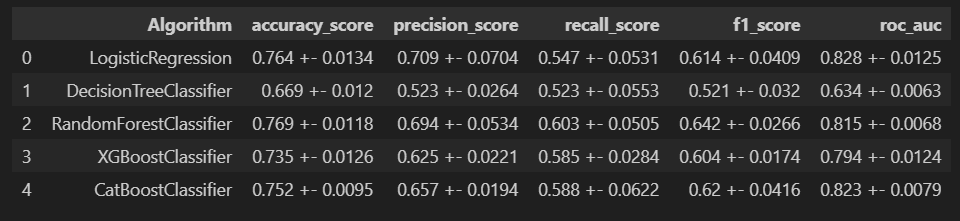

I will not modify features as I cannot recognize any significant rise in recall score

## Tuning ML Hyper-Parameters

I will use the recall metric for diabetes diagnosis because it is crucial to identify all positive cases of the disease. In this context, detecting all actual cases is more important than being highly precise in detection.

Recall measures the ability of the model to correctly identify all the true positive cases (i.e., all the people who actually have diabetes). In a medical diagnosis scenario, especially for serious conditions like diabetes, it is crucial not to miss any positive cases (false negatives), as untreated diabetes can lead to severe complications.

High recall ensures that fewer true diabetic cases are missed, even if that means there might be more false positives (people who are incorrectly diagnosed with diabetes).

Other metrics will be used for monitoring

In [ ]:
optuna_results = {}
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

### LogisticRegression

In [ ]:
def objective(trial):
    model = LogisticRegression(
        C=trial.suggest_float('C', 1e-3, 10, log=True),
        random_state=42
    )

    recall_scores = cross_val_score(model, X_train, y_train, scoring='recall', n_jobs=-1, cv=kfold)
    return recall_scores.mean()  # Return the mean recall score to optimize

study = optuna.create_study(direction="maximize", sampler=TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=50)

print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))

# Store the best param
best_params = study.best_params
optuna_results['LogisticRegression'] = trial.value

Number of completed trials: 50
Best trial:
	Best Score: 0.5649652616080795
	Best Params: 
		C = 0.005477508503455412,


In [136]:
optuna.visualization.plot_optimization_history(study)

### DecisionTreeClassifier

In [ ]:
def objective(trial):
    model = DecisionTreeClassifier(
        max_depth=trial.suggest_int('max_depth', 2, 30),
        min_samples_split = trial.suggest_int('min_samples_split', 2, 50),
        criterion = trial.suggest_categorical('criterion',['gini', 'entropy', 'log_loss']),
        random_state=42,
    )


    recall_scores = cross_val_score(model, X_train, y_train, scoring='recall', n_jobs=-1, cv=kfold)
    return recall_scores.mean()  

study = optuna.create_study(direction="maximize", sampler=TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=50)

print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))

# Store the best param
best_params = study.best_params
optuna_results['DecisionTreeClassifier'] = trial.value

Number of completed trials: 50
Best trial:
	Best Score: 0.6361994270634888
	Best Params: 
		max_depth = 16,
		min_samples_split = 45,
		criterion = log_loss,


### RandomForestClassifier

In [ ]:
def objective(trial):
    model = RandomForestClassifier(
        max_depth=trial.suggest_int('max_depth', 2, 30),
        n_estimators = trial.suggest_int("n_estimators", 2, 2000),
        criterion = trial.suggest_categorical('criterion',['gini', 'entropy', 'log_loss']),
        random_state=42,
    )


    recall_scores = cross_val_score(model, X_train, y_train, scoring='recall', n_jobs=-1, cv=kfold)
    return recall_scores.mean()  

study = optuna.create_study(direction="maximize", sampler=TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=50)

print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))

# Store the best param
best_params = study.best_params
optuna_results['RandomForestClassifier'] = trial.value

Number of completed trials: 50
Best trial:
	Best Score: 0.6256015127781777
	Best Params: 
		max_depth = 13,
		n_estimators = 546,
		criterion = entropy,


### XGBoostClassifier

In [ ]:
def objective(trial):
    model = XGBClassifier(
        objective='binary:logistic', 
        n_estimators = trial.suggest_int("n_estimators", 2, 2000),
        max_depth=trial.suggest_int('max_depth', 2, 10),
        n_jobs = -1,
        random_state=42)
    

    recall_scores = cross_val_score(model, X_train, y_train, scoring='recall', n_jobs=-1, cv=kfold)
    return recall_scores.mean()  

study = optuna.create_study(direction="maximize", sampler=TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=50)

print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))

# Store the best param
best_params = study.best_params
optuna_results['XGBClassifier'] = trial.value

Number of completed trials: 50
Best trial:
	Best Score: 0.6355606357807789
	Best Params: 
		n_estimators = 678,
		max_depth = 10,


### CatBoostClassifier

In [ ]:
def objective(trial):
    model = CatBoostClassifier(
        iterations = trial.suggest_int("iterations", 30, 300),
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log = True),
        depth =  trial.suggest_int("depth", 3, 12),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 2, 16),
        verbose = False, 
        random_state=42
        )
    
    
    recall_scores = cross_val_score(model, X_train, y_train, scoring='recall', n_jobs=-1, cv=kfold)
    return recall_scores.mean()  

study = optuna.create_study(direction="maximize", sampler=TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=50)

print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))

# Store the best param
best_params = study.best_params
optuna_results['CatBoostClassifier'] = trial.value

Number of completed trials: 50
Best trial:
	Best Score: 0.6304493647366515
	Best Params: 
		iterations = 249,
		learning_rate = 0.04392995754187038,
		depth = 11,
		min_data_in_leaf = 13,


In [290]:
optuna.visualization.plot_optimization_history(study)

In [289]:
optuna.visualization.plot_param_importances(study)

In [144]:
pd.DataFrame.from_dict(optuna_results, orient='index', columns = ['tuned_recall'])

,tuned_recall
LogisticRegression,0.564965
DecisionTreeClassifier,0.636199
RandomForestClassifier,0.625602
XGBClassifier,0.635561
CatBoostClassifier,0.630449


The best model is XGBClassifier

## Fitting the best model

In [148]:
params = {
    'n_estimators' : 678,
	'max_depth' : 10,
}

model = XGBClassifier(
        objective='binary:logistic', 
        n_jobs = -1,
        random_state=42,
        **params)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=678, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_binary = (y_pred_proba >= 0.5).astype(int)

In [178]:
print('Test accuracy =', accuracy_score(y_test, y_pred_binary))
print('Test precision =', precision_score(y_test, y_pred_binary))
print('Test recall =', recall_score(y_test, y_pred_binary))
print('Test f1 =', f1_score(y_test, y_pred_binary))
print('Test roc_auc =', roc_auc_score(y_test, y_pred_binary))


Test accuracy = 0.7337662337662337
Test precision = 0.609375
Test recall = 0.7090909090909091
Test f1 = 0.6554621848739496
Test roc_auc = 0.7282828282828282


In [287]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))

Confusion Matrix:
 [[74 25]
 [16 39]]


In [288]:
print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78        99
           1       0.61      0.71      0.66        55

    accuracy                           0.73       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



In [184]:
df.to_csv('../data/diabetes_dataset.csv', index=False)


# Save the model

In [189]:
output_file = '../bins/model.bin'

with open(output_file, 'wb') as f_out: 
    pickle.dump(model, f_out)

# Use the model

In [190]:
input_file  = '../bins/model.bin'


with open(input_file, 'rb') as f_in: 
    model = pickle.load(f_in)

In [191]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=678, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
X = X_test.sample(1).values
print('Case:', X)

y_pred = model.predict_proba(X)[0, 1]
print('Probability of diabete:', round(y_pred, 2))

In [3]:
import pkg_resources

# Get the list of currently installed packages
installed_packages = pkg_resources.working_set

# Write to requirements.txt
with open("requirements.txt", "w") as f:
    for pkg in installed_packages:
        f.write(f"{pkg.key}=={pkg.version}\n")

C:\Users\rustem_izmailov\AppData\Local\Temp\ipykernel_13664\2211553063.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
